In [ ]:
!pip install -q mlcroissant

In [ ]:
!pip install -q fiftyone

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
from google.colab import drive

from mlcroissant import Dataset

In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

### COCO/TFDS

In [ ]:
ds, ds_info = tfds.load('coco_captions', split='test', with_info=True)

In [ ]:
record_sets = ds.metadata.record_sets
print(record_sets)

In [ ]:
record_set_df = pd.DataFrame(ds.records(record_set=record_sets[0].uuid))
record_set_df.head()
record_set_df.info()

### Flickr30k/Croissant

In [ ]:
# Download Flickr30k metadata from hugging face
flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
records = flickr30k_ds.records("TEST")
records

In [ ]:
# Print the names of the available record sets
record_sets = flickr30k_ds.metadata.record_sets
print(record_sets)

In [ ]:
# Load the image metadata and captions into a dataframe
# NOTE: This does not actually load the images, just a pointer to them
flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
display(flickr30k_df.head())
flickr30k_df.info()

In [ ]:
np.unique(flickr30k_df["TEST/split"])

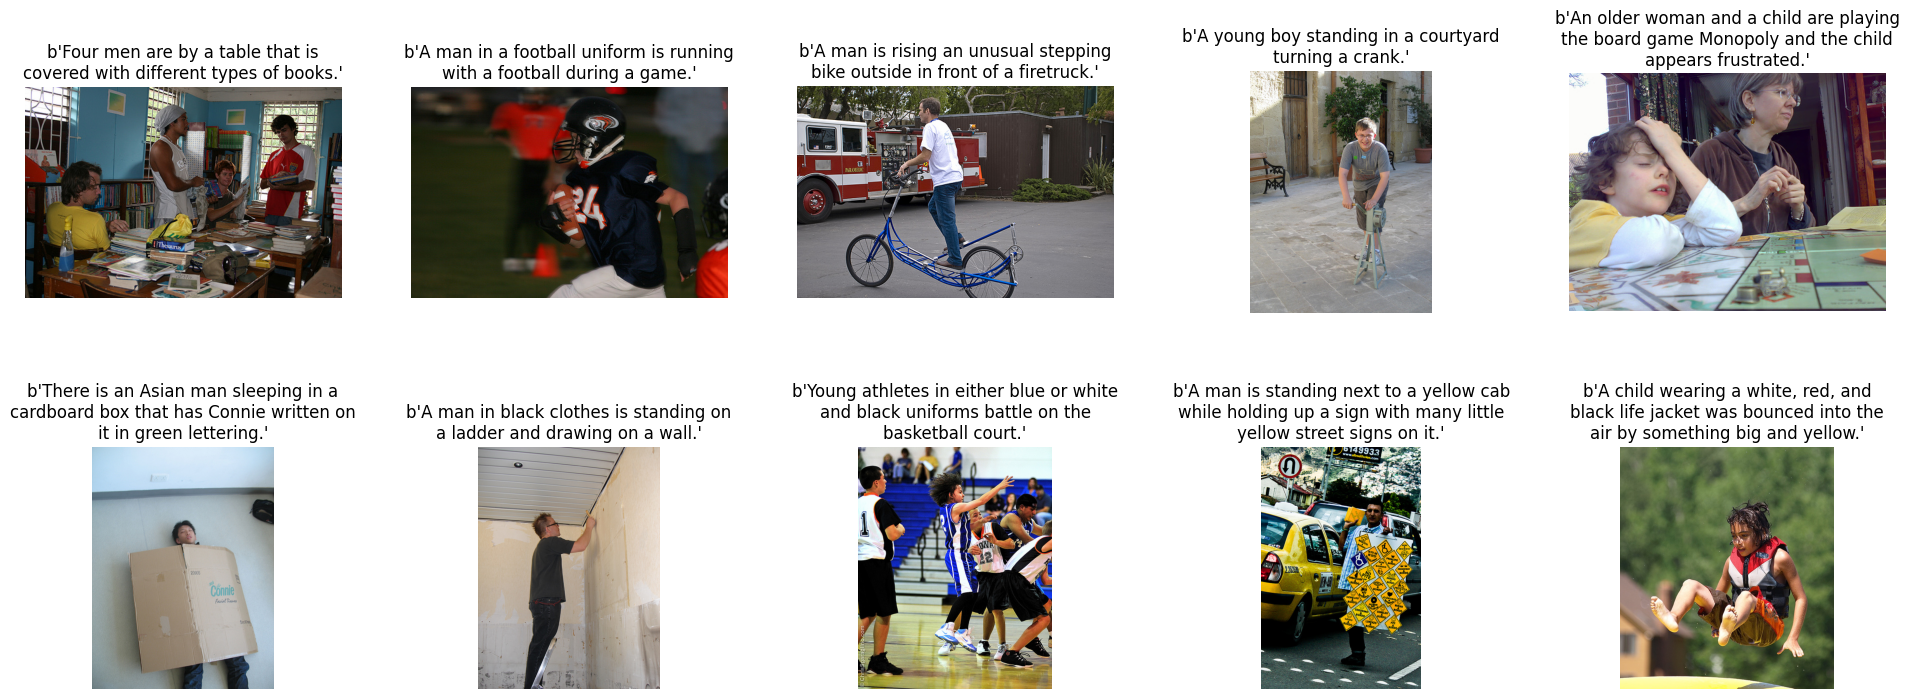

In [25]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

for i, ax in enumerate(axs):
  ax.imshow(rs["TEST/image"].iloc[i])
  caption = str(rs["TEST/caption"].iloc[i][0])
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

In [ ]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["TEST/split"] == b'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["TEST/split"] == b'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["TEST/split"] == b'val']
print(val_df.info())

In [ ]:
# NOTE: I am commenting this section out for now because this method of preprocessing will crash due to loading all the images into memory at once


# subset_df = record_set_df.sample(frac=0.01, random_state=42)
# subset_df.info()

In [ ]:
# print(*(caption for caption in subset_df["TEST/caption"].iloc[3]), sep='\n')
# subset_df["TEST/image"].iloc[3]

In [ ]:
# for i in range(len(record_set_df)):
#   print(i)
#   print(plt.imshow(record_set_df["TEST/image"].iloc[i]))
#   plt.show()

In [ ]:
# # Define a resizing function for PIL images
# def preprocess_image(pil_image):
#     img = tf.convert_to_tensor(pil_image)  # Convert PIL image to tensor
#     img = tf.image.resize(img, [224, 224])  # Resize to target dimensions
#     img = img / 255.0  # Scale pixel values to [0, 1] range
#     return img

# # Apply the function to each image in your DataFrame
# subset_df['resized_image'] = subset_df['TEST/image'].apply(preprocess_image)


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((list(subset_df['resized_image']), list(subset_df['TEST/caption'])))
# batch_size = 32
# dataset = dataset.batch(batch_size).shuffle(buffer_size=100)
# print(dataset.element_spec)

In [ ]:
# for batch in dataset.take(1):
#   images, captions = batch
#   for image, image_captions in zip(images[:3], captions[:3]):
#     print(image_captions)
#     plt.imshow(image)
#     plt.show()

In [ ]:
# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator_from_croissant(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)
    images = data["TEST/image"]
    image_tensors = [tf.convert_to_tensor(img) for img in images]
    image_tensors = [tf.image.resize(img, [im_width, im_height]) for img in image_tensors]
    image_tensors = [img/255.0 for img in image_tensors]
    yield np.array(image_tensors)

In [ ]:
import random

In [ ]:
train_df["TEST/caption"].iloc[0][4]

In [ ]:
idx = 10
bs = 64
low = idx * bs
high = min(low + bs, len(train_df))
batch = train_df[low:high]

In [ ]:
batch

In [ ]:
class CroissantDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __getitem__(self, idx):
    #batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]

    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))
    batch = self.data[low:high]

    images = batch["TEST/image"]
    image_tensors = [tf.convert_to_tensor(img) for img in images]
    image_tensors = [tf.image.resize(img, [self.im_width, self.im_height]) for img in image_tensors]
    image_tensors = [img/255.0 for img in image_tensors]

    caption_idx = random.randint(0, 4)
    #captions = []
    #captions = batch["TEST/caption"][caption_idx]

    return np.array(image_tensors)

  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

In [ ]:
train_generator = CroissantDataGenerator(train_df, 224, 224, batch_size=64)

In [ ]:
np.ceil(len(train_df)/64)

In [ ]:
next(data_generator_from_croissant(train_df, 224, 224, batch_size=64)).shape

In [ ]:
# plt.imshow(next(data_generator_from_croissant(train_df, 128, 128, batch_size=64))[0])

In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 64
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 10

train_generator = data_generator_from_croissant(train_df, 224, 224, batch_size=64)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

In [ ]:
(test_end_time - test_start_time)/60

### COCO/FiftyOne

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
! cd